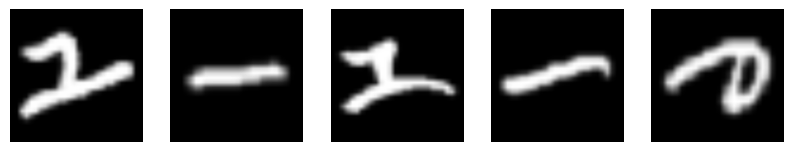

In [ ]:
import torch
import torch.nn as nn
import torchvision as tv
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchsummary import summary
import pandas as pd
# Download and load the EMNIST datase
# Define a function to show a grid of images
transform = tv.transforms.Compose([
    #  tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])
train_dataset = tv.datasets.EMNIST(root='.', train=True, transform=transform, download=True,split='mnist')
def show_images(images):
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(images):
        plt.subplot(5, 5, i+1)
        plt.imshow(image.squeeze().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()

# Show a sample of 25 images from the dataset
sample_images = [train_dataset[i][0] for i in range(5)]
show_images(sample_images)
transform = tv.transforms.Compose([
      tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])
import gc

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def AUC(model,data):
  n=0
  acc_sum = 0.0
  model.eval()
  for X,y in data:
    X,y = X.to(device),y.to(device)
    y_pred = model(X)
    acc_sum += (y_pred.argmax(axis=1)== y).sum().item()
    n += y.shape[0]
  return acc_sum/n


In [ ]:


def LOSS(model,data):
  loss = nn.CrossEntropyLoss(reduction='sum')
  model.eval()
  train_l_sum,n = 0.0,0
  for X,y in data:
    X,y = X.to(device),y.to(device)
    y_pred = model(X)
    l = loss(y_pred,y)
    train_l_sum  += l.item()
    n += y.shape[0]
  return train_l_sum/n

In [ ]:
def train(model, train_iter, test_iter,trainer,epochs=10):

    l_arr = []
    model.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    model.train()

    for epoch in range(epochs):
      train_l_sum,n,train_acc_sum = 0.0, 0,0.0
      for i,(X,y) in enumerate(train_iter):

        X,y = X.to(device),y.to(device)
        trainer.zero_grad()
        y_pred = model(X)
        l = loss(y_pred,y)
        l.backward()
        trainer.step()
        train_l_sum  += l.item()
        train_acc_sum += (y_pred.argmax(axis=1)==y).sum().item()
        n += y.shape[0]
        torch.cuda.empty_cache()
        #if epoch % 2:
         # print(f"""Batch {i} LOSS =  {train_l_sum/n} AUC = {train_acc_sum/n} """)
     # if epoch % 2 :
     #   test_acc = AUC(model,test_iter)
     #   print(f"""----------------AUC test = {test_acc}------------------------ """)
        del X
        del y
      l_arr.append(train_l_sum/n)
      gc.collect()
    return pd.DataFrame({'epoch':list(range(epochs)),'Loss':l_arr})



In [ ]:
dataset = tv.datasets.EMNIST(root='.', train=True, transform=transform, download=True,split='mnist')

In [ ]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import numpy as np
indices = np.arange(len(dataset))
train_indices, test_indices = train_test_split(indices, train_size=20*10, stratify=dataset.targets)

# Warp into Subsets and DataLoaders
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

In [ ]:
targets = [train_dataset[i][1] for i in range(len(train_dataset))]

In [ ]:
df = pd.DataFrame({'target':targets})

In [ ]:
df['count'] = 1
df.groupby('target').count()

,count
target,
0,20
1,20
2,20
3,20
4,20
5,20
6,20
7,20
8,20


In [ ]:
BATCH_SIZE = 10
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

# RESNET

In [ ]:
model = tv.models.resnet18(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model.classifier = nn.Linear(in_features=2208, out_features=len(targets))

In [ ]:

print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
import torch

torch.cuda.empty_cache()

In [ ]:
res_results = train(model, train_iter, test_iter, trainer, 10)

Batch 0 LOSS =  1.2320262908935546 AUC = 0.7 
Batch 1 LOSS =  1.010163140296936 AUC = 0.75 
Batch 2 LOSS =  1.0538171609242757 AUC = 0.7 
Batch 3 LOSS =  1.0202186226844787 AUC = 0.7 
Batch 4 LOSS =  1.0111723995208741 AUC = 0.7 
Batch 5 LOSS =  0.9613557577133178 AUC = 0.7166666666666667 
Batch 6 LOSS =  0.9695415837424142 AUC = 0.7 
Batch 7 LOSS =  0.9687011778354645 AUC = 0.6875 
Batch 8 LOSS =  0.9645202371809217 AUC = 0.6888888888888889 
Batch 9 LOSS =  1.0117461347579957 AUC = 0.68 
Batch 10 LOSS =  0.9865175290541215 AUC = 0.7 
Batch 11 LOSS =  0.9834757844607035 AUC = 0.7083333333333334 
Batch 12 LOSS =  0.9601389261392447 AUC = 0.7230769230769231 
Batch 13 LOSS =  0.9754726307732718 AUC = 0.7214285714285714 
Batch 14 LOSS =  0.9472237809499104 AUC = 0.7333333333333333 
Batch 15 LOSS =  0.9175902217626571 AUC = 0.7375 
Batch 16 LOSS =  0.9023504313300638 AUC = 0.7352941176470589 
Batch 17 LOSS =  0.9137808746761746 AUC = 0.7333333333333333 
Batch 18 LOSS =  0.9268242534838225 A

# VGG 16

In [ ]:
transform = tv.transforms.Compose([
      tv.transforms.Grayscale(3),
    tv.transforms.Resize((32,32)),
    tv.transforms.ToTensor()
])
import gc

In [ ]:
model = tv.models.vgg16(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model.classifier = nn.Linear(in_features=25088, out_features=len(targets))

In [ ]:

params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
vgg_results = train(model, train_iter, test_iter, trainer, 10)

Batch 0 LOSS =  2.505255126953125 AUC = 0.2 
Batch 1 LOSS =  2.441308784484863 AUC = 0.15 
Batch 2 LOSS =  2.3995992660522463 AUC = 0.13333333333333333 
Batch 3 LOSS =  2.4573147296905518 AUC = 0.125 
Batch 4 LOSS =  2.475585479736328 AUC = 0.1 
Batch 5 LOSS =  2.464894739786784 AUC = 0.1 
Batch 6 LOSS =  2.483324759347098 AUC = 0.08571428571428572 
Batch 7 LOSS =  2.4481352090835573 AUC = 0.1 
Batch 8 LOSS =  2.441251775953505 AUC = 0.08888888888888889 
Batch 9 LOSS =  2.475811023712158 AUC = 0.08 
Batch 10 LOSS =  2.4661181363192473 AUC = 0.07272727272727272 
Batch 11 LOSS =  2.4513347148895264 AUC = 0.06666666666666667 
Batch 12 LOSS =  2.4474422894991363 AUC = 0.06923076923076923 
Batch 13 LOSS =  2.4363340105329243 AUC = 0.08571428571428572 
Batch 14 LOSS =  2.434149703979492 AUC = 0.08666666666666667 
Batch 15 LOSS =  2.426364469528198 AUC = 0.09375 
Batch 16 LOSS =  2.4258434520048255 AUC = 0.08823529411764706 
Batch 17 LOSS =  2.4242963896857366 AUC = 0.08333333333333333 
Batch

In [ ]:
224*224

50176

# Inception v3

In [ ]:
transform = tv.transforms.Compose([
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])


dataset = tv.datasets.EMNIST(root='.', train=True, transform=transform, download=True,split='mnist')

indices = np.arange(len(dataset))
train_indices, test_indices = train_test_split(indices, train_size=50*10, stratify=dataset.targets)

# Warp into Subsets and DataLoaders
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

In [ ]:
model = tv.models.inception_v3(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [ ]:
model.classifier = nn.Linear(model.fc.in_features, len(targets))



In [ ]:
transform = tv.transforms.Compose([
      tv.transforms.Grayscale(3),
    tv.transforms.Resize((299,299)),
    tv.transforms.ToTensor()
])
import gc
dataset = tv.datasets.EMNIST(root='.', train=True, transform=transform, download=True,split='mnist')
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import numpy as np
indices = np.arange(len(dataset))
train_indices, test_indices = train_test_split(indices, train_size=50*10, stratify=dataset.targets)

# Warp into Subsets and DataLoaders
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)



In [ ]:

params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
def train_1(model, train_iter, test_iter,trainer,epochs=10):
  l_arr = []
  model.to(device)
  loss = nn.CrossEntropyLoss(reduction='sum')
  model.train()

  for epoch in range(epochs):
    train_l_sum,n,train_acc_sum = 0.0, 0,0.0
    for i,(X,y) in enumerate(train_iter):


      X,y = X.to(device),y.to(device)
      trainer.zero_grad()
      _,y_pred = model(X)
      l = loss(y_pred,y)
      l.backward()
      trainer.step()
      train_l_sum  += l.item()
      train_acc_sum += (y_pred.argmax(axis=1)==y).sum().item()
      n += y.shape[0]
      torch.cuda.empty_cache()
     # if i % 2:
     #   print(f"""Batch {i} LOSS =  {train_l_sum/n} AUC = {train_acc_sum/n} """)
    #if epoch % 2 :
    #  test_acc = AUC(model,test_iter)
    #  print(f"""----------------AUC test = {test_acc}------------------------ """)

    l_arr.append(train_l_sum/n)
  return pd.DataFrame({'epoch':list(range(epochs)),'Loss':l_arr})
BATCH_SIZE = 10
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)
inception_results = train_1(model, train_iter, test_iter, trainer, 10)

# DenseNet 161

In [ ]:
transform_ = tv.transforms.Compose([
    tv.transforms.Resize((32, 32)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])


dataset = tv.datasets.EMNIST(root='.', train=True, transform=transform, download=True,split='mnist')

indices = np.arange(len(dataset))
train_indices, test_indices = train_test_split(indices, train_size=50*10, stratify=dataset.targets)

# Warp into Subsets and DataLoaders
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

In [ ]:
model = tv.models.densenet161(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model.classifier = nn.Linear(in_features=2208, out_features=len(targets))

In [ ]:

params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


In [ ]:
BATCH_SIZE = 10
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)
dense_results = train(model, train_iter, test_iter, trainer, 10)

# Results

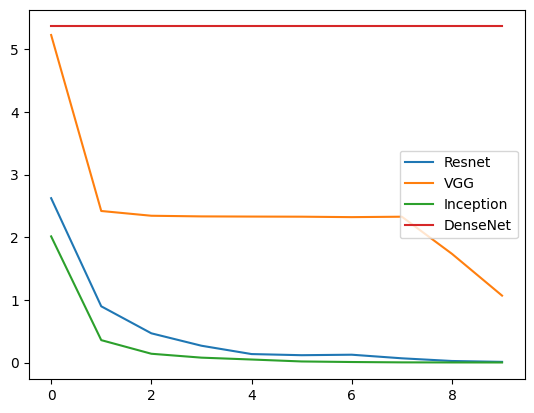

In [ ]:
# inception_results , vgg_results ,res_results ,dense_results
import matplotlib.pyplot as plt

# Plot
plt.plot(res_results['epoch'], res_results['Loss'],label='Resnet')
plt.plot(vgg_results['epoch'], vgg_results['Loss'],label='VGG')
plt.plot(inception_results ['epoch'], inception_results ['Loss'],label='Inception')
plt.plot(dense_results ['epoch'],dense_results  ['Loss'],label='DenseNet')
plt.legend()
plt.show()